In [2]:
# import necessary modules
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import netCDF4 as nc
from mpl_toolkits.basemap import Basemap
from sklearn.decomposition import PCA
import matplotlib.gridspec as gridspec
from matplotlib.backends.backend_pdf import PdfPages
from mpl_toolkits.axes_grid1 import make_axes_locatable
from datetime import datetime, timedelta
import pandas as pd
from scipy.spatial import distance_matrix
from matplotlib import cm as cm
from matplotlib.collections import PatchCollection
from matplotlib.patches import Polygon
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
import math

In [3]:
#get the file path for loading, data file is under the same dir with the notebook
filename="20121015_00_ecmwf_ensemble_forecast.PRESSURE_LEVELS.EUR_LL10.120.pl.nc"
foldername="ECWMF Datasets"
filepath=os.path.join(os.path.dirname(os.getcwd()),foldername,filename)

# read the raw data and extract the needed data
# exrtact the value of Geopotential under the pressure of 500 hPA in the certain
Pressure_Levels_data = nc.Dataset(filepath,"r")
g = 9.80655
# get all the dimension value
nd_1,nd_2,nd_3,nd_4,nd_5 = Pressure_Levels_data.variables['Geopotential_isobaric'][:].shape
# get the necessary raw data
Geopotential_Isobaric_500 = Pressure_Levels_data.variables['Geopotential_isobaric'][0,:,7,:,:]/g
# reshape the dataset into form of (51,41*101)
Geopotential_Isobaric_500_reshaped = np.reshape(Geopotential_Isobaric_500,(nd_2, nd_4 * nd_5))
# prepare the longitude and latitude value for contour
longitude = Pressure_Levels_data['lon'][:]
latitude = Pressure_Levels_data['lat'][:]
(lon, lat) = np.meshgrid(longitude, latitude)

# use PCA to reduce dimensions under the condition of reaching 80% of all the member infomation
exp_var = 0
n_pc = 0
while exp_var < 0.8:
    n_pc = n_pc + 1
    pca = PCA(n_components = n_pc)
    pca.fit(Geopotential_Isobaric_500_reshaped)
    exp_var = sum(pca.explained_variance_ratio_)

# get the transformed raw data in the dimension-reduced space    
pca_transformed_data = pca.transform(Geopotential_Isobaric_500_reshaped)

#get the time variable
times=Pressure_Levels_data.variables["time"]
#get the time number
arrDateEnd=nc.num2date(times[:],units=times.units)
#get the time in date format
dateEndDate = datetime.date(arrDateEnd[0]).strftime("%d %b %Y")
dateEndMin = datetime.date(arrDateEnd[0]).strftime("%H:%M")
dateStart=datetime.date(arrDateEnd[0])-timedelta(hours=120)
dateStartDate=dateStart.strftime("%d %b %Y")
dateStartMin=dateStart.strftime("%H:%M")

In [5]:
mapBaseMean=np.zeros((nd_4,nd_5))
mapBaseSTDEV=np.zeros((nd_4,nd_5))


for i in range(nd_4):
    for j in range(nd_5):
        arr=[]
        for n in range(nd_2):
            arr.append(Geopotential_Isobaric_500[n,i,j])
        mean=np.mean(arr)
        STDEV=np.std(arr)
        mapBaseMean[i][j]=mean
        mapBaseSTDEV[i][j]=STDEV

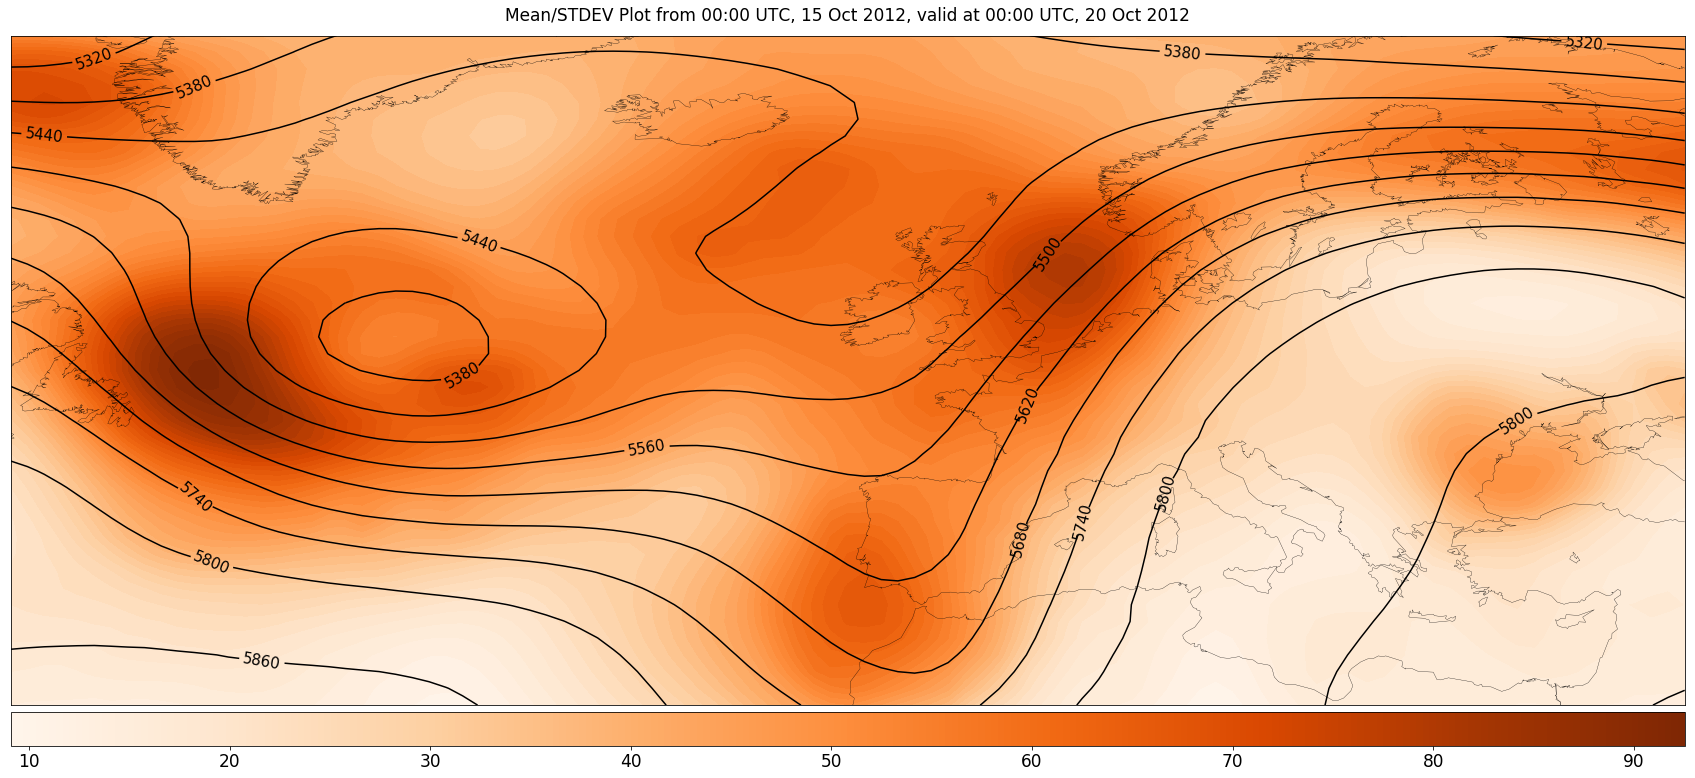

In [6]:
fig = plt.subplots(figsize = (30,20))
plt.subplots_adjust(hspace = 0, wspace = 0)

ax=plt.gca()
map = Basemap(projection ='cyl',llcrnrlat = latitude[-1],urcrnrlat = latitude[0],resolution ='l', llcrnrlon = longitude[0], urcrnrlon = longitude[-1])
map.drawcoastlines(linewidth = 0.3)
map.contourf(lon, lat, mapBaseSTDEV,cmap = 'Oranges',levels=50)
ct=map.contour(lon, lat, mapBaseMean,colors='k',levels=np.linspace(5200,5920,12,endpoint=False))

ax.clabel(ct, fontsize = 15, fmt = '%.0f')
ax.set_title("Mean/STDEV Plot from {0} UTC, {1}, valid at {2} UTC, {3}".format(dateStartMin,dateStartDate,dateEndMin,dateEndDate),fontsize = 17, pad = 15)    
m = plt.cm.ScalarMappable(cmap=matplotlib.cm.Oranges)
m.set_array(mapBaseSTDEV)
divider = make_axes_locatable(ax)
cax = divider.append_axes("bottom", size="5%", pad=0.1)
cb=plt.colorbar(m,orientation="horizontal",cax=cax)
cb.ax.tick_params(labelsize=17)

In [7]:
def draw_patches(ax,point1,point2,point3,point4,edgecolor,zorder):
    # Fill two polygon shapes
    patches = []

    rect = np.array([point1,point2,point3,point4])
    patches.append(Polygon(rect))

    ax.add_collection(PatchCollection(patches, facecolor='None', edgecolor=edgecolor, linewidths=1.5,zorder=zorder))

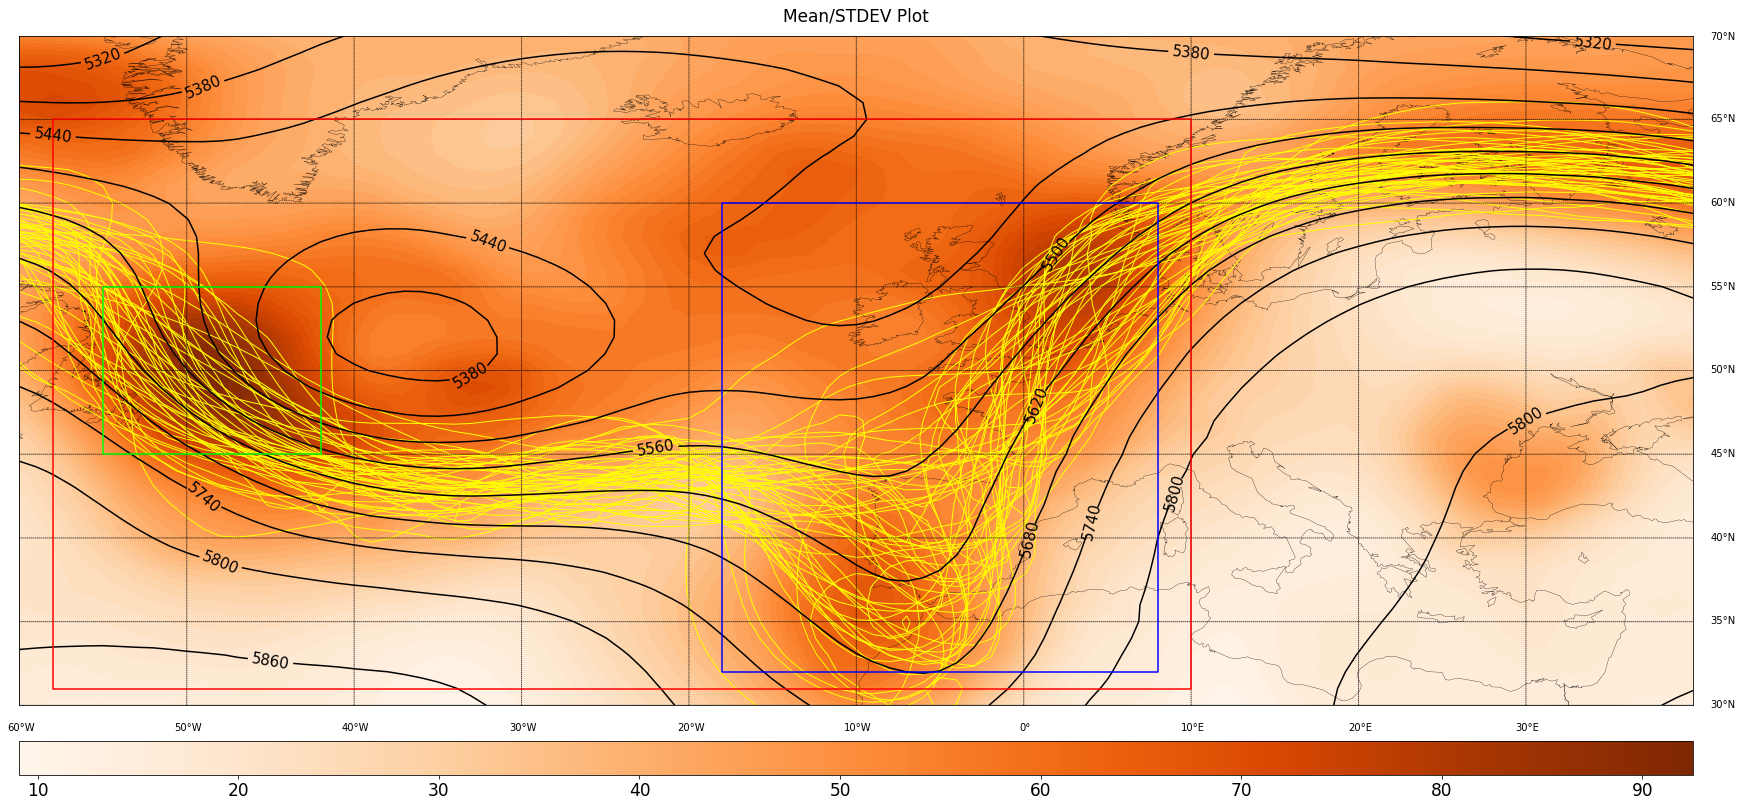

In [8]:
fig = plt.subplots(figsize = (30,20))
plt.subplots_adjust(hspace = 0, wspace = 0)

ax=plt.gca()
map = Basemap(projection ='cyl',llcrnrlat = latitude[-1],urcrnrlat = latitude[0],resolution ='l', llcrnrlon = longitude[0], urcrnrlon = longitude[-1])
map.drawcoastlines(linewidth = 0.3)
map.contourf(lon, lat, mapBaseSTDEV,cmap = 'Oranges',levels=50)
ct=map.contour(lon, lat, mapBaseMean,colors='k',levels=np.linspace(5200,5920,12,endpoint=False),zorder=3)
map.drawparallels(np.arange(30,90,5),labels=[False,True,True,False])
map.drawmeridians(np.arange(-60,40,10),labels=[True,False,False,True])
for i in range(51):
    map.contour(lon, lat, Geopotential_Isobaric_500[i, :, :], levels = [5600], colors = 'yellow', linewidths = 1)

ax.clabel(ct, fontsize = 15, fmt = '%.0f')
ax.set_title("Mean/STDEV Plot",fontsize = 17, pad = 15)    
m = plt.cm.ScalarMappable(cmap=matplotlib.cm.Oranges)
m.set_array(mapBaseSTDEV)
divider = make_axes_locatable(ax)
cax = divider.append_axes("bottom", size="5%", pad=0.5)
cb=plt.colorbar(m,orientation="horizontal",cax=cax)
cb.ax.tick_params(labelsize=17)

draw_patches(ax,[-55,45],[-55,55],[-42,55],[-42,45],'lime',3)
draw_patches(ax,[-18,32],[-18,60],[8,60],[8,32],'blue',3)
draw_patches(ax,[-58,31],[-58,65],[10,65],[10,31],'red',3)

In [9]:
def Get_Subgrid(longitude,latitude,bottomLeft,topRight):
    lonStart=(np.abs(longitude - bottomLeft[0])).argmin()
    lonEnd=(np.abs(longitude - topRight[0])).argmin()
    latStart=(np.abs(latitude - bottomLeft[1])).argmin()
    latEnd=(np.abs(latitude - topRight[1])).argmin()
    
    return lonStart,lonEnd,latStart,latEnd

def Get_Meshgrid(lonStart,lonEnd,latStart,latEnd):
    long=longitude[lonStart:lonEnd+1]
    lati=latitude[latEnd:latStart+1]
    (lon,lat)=np.meshgrid(long,lati)
    
    return lon,lat

def Get_Area_Data(data,lonStart,lonEnd,latStart,latEnd):
    areaData=data[:,latEnd:latStart+1,lonStart:lonEnd+1]
    
    return areaData

def Reshape_New_Data(areaData):
    dim1,dim2,dim3=areaData.shape
    reshapedData=np.reshape(areaData,(dim1,dim2*dim3))
    return reshapedData

def PCA_Run(data):
    exp_var = 0
    n_pc = 0
    while exp_var < 0.8:
        n_pc = n_pc + 1
        pca = PCA(n_components = n_pc)
        pca.fit(data)
        exp_var = sum(pca.explained_variance_ratio_)
        
    return pca

#lonStart,lonEnd,latStart,latEnd = Get_Subgrid(longitude,latitude,[-60,30],[40,70])
lonStart,lonEnd,latStart,latEnd = Get_Subgrid(longitude,latitude,[-55,45],[-42,55])
#lonStart,lonEnd,latStart,latEnd = Get_Subgrid(longitude,latitude,[-58,31],[10,65])
newLon,newLat=Get_Meshgrid(lonStart,lonEnd,latStart,latEnd)
secData = Get_Area_Data(Geopotential_Isobaric_500,lonStart,lonEnd,latStart,latEnd)
reshapeData=Reshape_New_Data(secData)
PCA_=PCA_Run(reshapeData)
transformedData=PCA_.transform(reshapeData)

# use kmeans to cluster the transformed data
kmeans = KMeans(init = "k-means++", n_clusters = 3, n_init = 10).fit(transformedData)

def F1_Function(areadata,x,y):
    coordMean=np.mean(areadata[:,x,y])
    coordSum=np.sum([(areadata[idx,x,y]-coordMean)**2 for idx in range(len(areadata))])
    
    return coordSum

def Fk_Function(areadata,kmeans_labels,x,y):   
    # get the cluster result in forms of labels
    labels = kmeans_labels
    # extract unique label
    unique_labels = set(labels)
    clusterSum=0
    for e in unique_labels:
        subclusterIndex=np.where(labels==e)
        subclusterMean=np.mean(areadata[subclusterIndex,x,y])
        subclusterSum=np.sum([(areadata[idx,x,y]-subclusterMean)**2 for idx in subclusterIndex])
        clusterSum=subclusterSum + clusterSum

    return clusterSum

def Rk_Function(x,y,kmeans_labels):
    f1=F1_Function(secData,x,y)
    f_temp=Fk_Function(secData,kmeans_labels,x,y)
    
    return 1-np.sqrt(f_temp/f1)

arr_STDEV = np.zeros(secData[0].shape)
n1,n2=arr_STDEV.shape
for i in range(n1):
    for j in range(n2):
        arr_STDEV[i][j]=Rk_Function(i,j,kmeans.labels_)

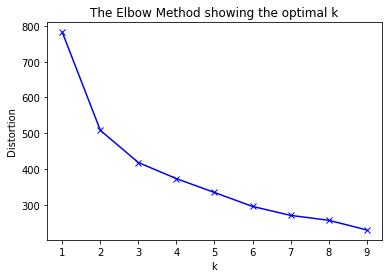

In [10]:
colors = ['b', 'g', 'r']
markers = ['o', 'v', 's']

# k means determine k
distortions = []
inertia=[]
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(transformedData)
    kmeanModel.fit(transformedData)
    distortions.append(sum(np.min(cdist(transformedData, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / transformedData.shape[0])
    inertia.append(kmeanModel.inertia_)
    
# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [529]:
#a,b,c,d=Get_Subgrid(longitude,latitude,[-18,32],[8,60])
a,b,c,d=Get_Subgrid(longitude,latitude,[-55,45],[-42,55])
#a,b,c,d=Get_Subgrid(longitude,latitude,[-58,31],[10,65])
newlon,newlat=Get_Meshgrid(a,b,c,d)

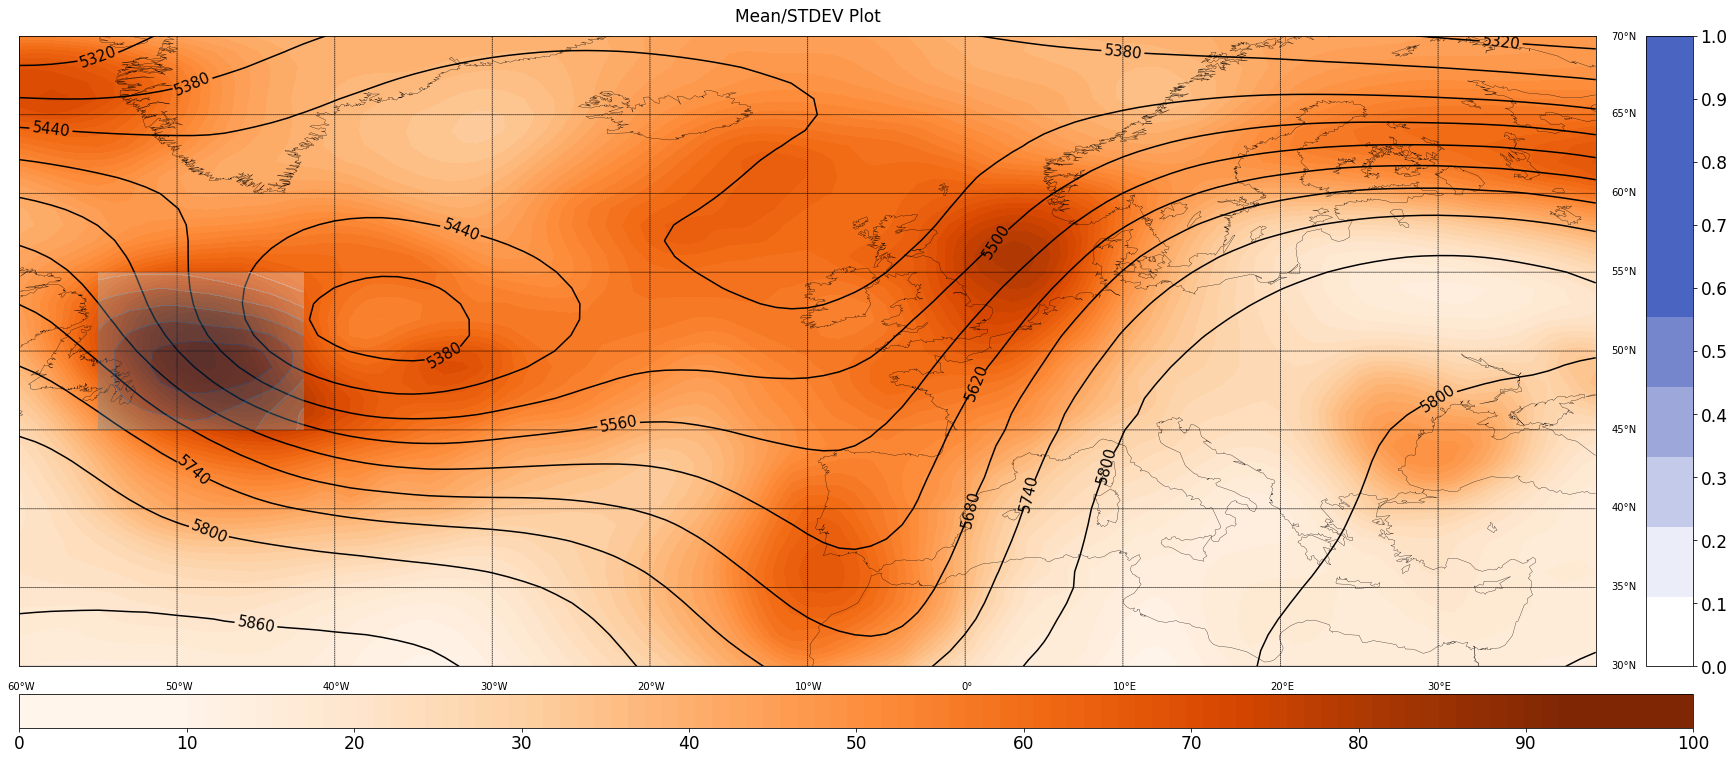

In [535]:
fig = plt.subplots(figsize = (30,20))
plt.subplots_adjust(hspace = 0, wspace = 0)

ax=plt.gca()
map = Basemap(projection ='cyl',llcrnrlat = latitude[-1],urcrnrlat = latitude[0],resolution ='l', llcrnrlon = longitude[0], urcrnrlon = longitude[-1])
map.drawcoastlines(linewidth = 0.3)
map.contourf(lon, lat, mapBaseSTDEV,cmap = 'Oranges',levels=50)
ct=map.contour(lon, lat, mapBaseMean,colors='k',levels=np.linspace(5200,5920,12,endpoint=False),zorder=3)
map.contourf(newlon, newlat, new_arr,alpha=.3,cmap = 'Blues',zorder=3)
#map.contourf(lon, lat, new_arr,alpha=.5,levels=5,cmap = 'Blues',zorder=3)
map.drawparallels(np.arange(30,90,5),labels=[False,True,True,False])
map.drawmeridians(np.arange(-60,40,10),labels=[True,False,False,True])

colors = ("#FFFFFF","#EBEDF8","#D8DBF1","#C4CAE9","#B1B8E2","#9DA7DA","#8A96D3","#7686CC","#6175C6","#4A65C1")
CustomCmap = matplotlib.colors.ListedColormap(colors)

ax.clabel(ct, fontsize = 15, fmt = '%.0f')
ax.set_title("Mean/STDEV Plot",fontsize = 17, pad = 15)    
m = plt.cm.ScalarMappable(cmap=matplotlib.cm.Oranges)
m.set_array(mapBaseSTDEV)
divider = make_axes_locatable(ax)
cax = divider.append_axes("bottom", size="5%", pad=0.7)
cb=plt.colorbar(m,boundaries=np.linspace(0,100,100,endpoint=True),ticks=[10*i for i in range(11)],orientation="horizontal",cax=cax)
cb.ax.tick_params(labelsize=17)

m = plt.cm.ScalarMappable(cmap=CustomCmap)
m.set_array(arr_STDEV)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.7)
cb=plt.colorbar(m,boundaries=np.linspace(0,1,10,endpoint=True),ticks=[0.1*i for i in range(11)],orientation="vertical",cax=cax)
cb.ax.tick_params(labelsize=17)


#draw_patches(ax,[-55,45],[-55,55],[-42,55],[-42,45],'lime',3)
#draw_patches(ax,[-60,30],[-60,70],[40,70],[40,30],'blue',3)
#draw_patches(ax,[-58,31],[-58,65],[10,65],[10,31],'red',3)

In [533]:
new_arr=np.around(arr_STDEV,decimals=2)

In [534]:
new_arr

array([[0.21, 0.22, 0.23, 0.23, 0.23, 0.23, 0.22, 0.2 , 0.19, 0.17, 0.15,
        0.12, 0.1 , 0.08],
       [0.27, 0.29, 0.3 , 0.31, 0.32, 0.31, 0.3 , 0.29, 0.27, 0.25, 0.23,
        0.2 , 0.17, 0.14],
       [0.33, 0.35, 0.37, 0.38, 0.39, 0.39, 0.38, 0.37, 0.36, 0.34, 0.32,
        0.3 , 0.26, 0.22],
       [0.38, 0.41, 0.44, 0.45, 0.47, 0.47, 0.46, 0.45, 0.44, 0.43, 0.42,
        0.39, 0.36, 0.31],
       [0.41, 0.45, 0.49, 0.52, 0.53, 0.54, 0.54, 0.53, 0.52, 0.52, 0.5 ,
        0.48, 0.44, 0.4 ],
       [0.43, 0.48, 0.52, 0.55, 0.57, 0.58, 0.59, 0.6 , 0.59, 0.59, 0.57,
        0.54, 0.5 , 0.44],
       [0.44, 0.48, 0.52, 0.55, 0.58, 0.6 , 0.61, 0.62, 0.62, 0.61, 0.59,
        0.56, 0.5 , 0.44],
       [0.44, 0.48, 0.51, 0.54, 0.56, 0.58, 0.58, 0.59, 0.59, 0.57, 0.55,
        0.51, 0.45, 0.39],
       [0.44, 0.46, 0.49, 0.51, 0.53, 0.54, 0.55, 0.54, 0.52, 0.5 , 0.47,
        0.44, 0.39, 0.34],
       [0.42, 0.44, 0.45, 0.47, 0.48, 0.49, 0.5 , 0.49, 0.47, 0.45, 0.42,
        0.39, 0.3

In [515]:
arr_STDEV

array([[0.05194381, 0.06155397, 0.07139438, ..., 0.02446893, 0.02067862,
        0.01660176],
       [0.08638269, 0.09344775, 0.09899185, ..., 0.03236385, 0.02870904,
        0.02464528],
       [0.08646917, 0.0896064 , 0.09255929, ..., 0.04007501, 0.03561525,
        0.03115789],
       ...,
       [0.07312122, 0.07664122, 0.08386804, ..., 0.05385906, 0.05022145,
        0.05170963],
       [0.06879081, 0.0738738 , 0.08184566, ..., 0.05404577, 0.05244806,
        0.05459484],
       [0.05857281, 0.06717319, 0.07259251, ..., 0.05546532, 0.05945693,
        0.05690266]])